In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")

CSV file saved as dataset.csv


In [5]:
df.head()

,image_path,category
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented


category
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


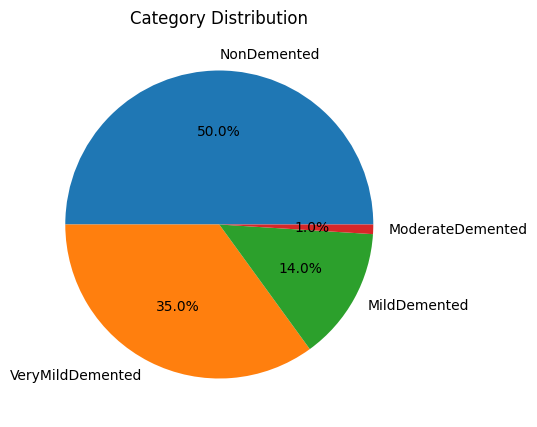

In [6]:
category_counts = df["category"].value_counts()
print(category_counts)

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

In [7]:
def show_random_images(column, number_of_images_to_show=5, grey=False):
    categories = df["category"].unique()
    
    images_per_category = number_of_images_to_show
    
    plt.figure(figsize=(15, len(categories) * 5))
    for i, category in enumerate(categories):
        category_images = df[df["category"] == category][column].tolist()
        
        for j in range(min(len(category_images), images_per_category)):
            img_data = category_images[j]
            if column != "image_path":
                img = img_data
            else:
                img = cv2.imread(img_data)
                
            if column == "image_path":
                if grey:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(categories), images_per_category, i * images_per_category + j + 1)
            
            if grey:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img)
            
            plt.axis("off")
            plt.title(f"{category}")
    
    plt.tight_layout()
    plt.show()

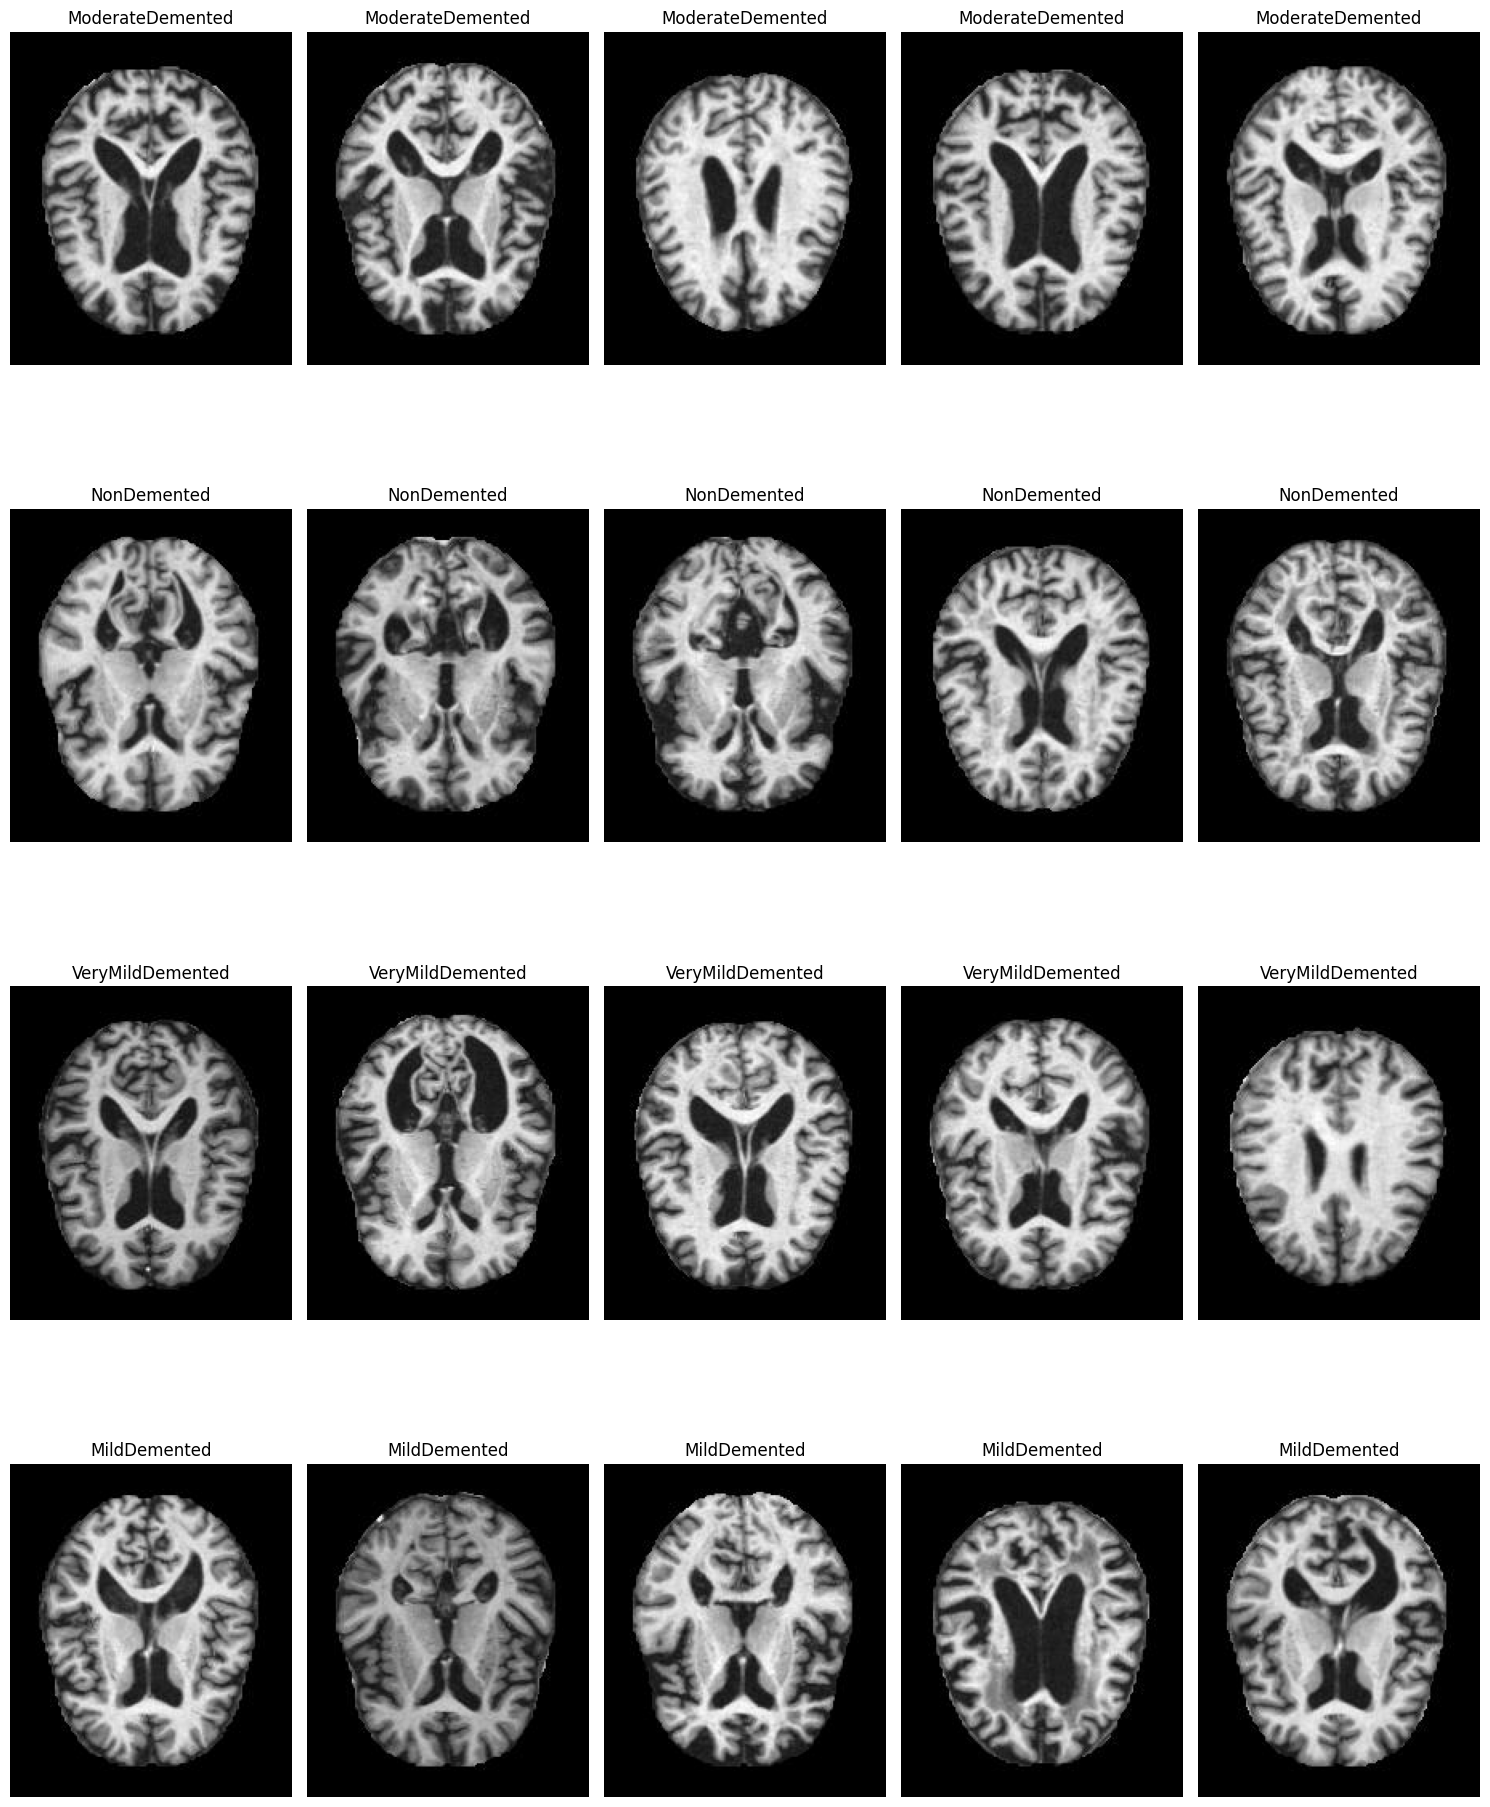

In [8]:
show_random_images("image_path", 5, False)

In [9]:
class_names = sorted(df['category'].unique())
df_encoded = pd.get_dummies(df['category'], dtype=int)
df_final = pd.concat([df, df_encoded], axis=1)
df_final = df_final.drop(columns=['category'])

In [10]:
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [11]:
oversampling_strategy = {
    'ModerateDemented': 4.0,
    'MildDemented': 2.5,
    'VeryMildDemented': 1.5,
    'NonDemented': 1
}

data_frames_to_concat = [train_df]

for class_name, multiplier in oversampling_strategy.items():
    
    if class_name in train_df.columns:
        print(f"Processing {class_name}: Adding {multiplier} amount...")
        
        class_rows = train_df[train_df[class_name] == 1]
        
        oversampled_rows = class_rows.sample(frac=multiplier, replace=True, random_state=42)
        
        data_frames_to_concat.append(oversampled_rows)

train_df_balanced = pd.concat(data_frames_to_concat, ignore_index=True)

train_df_balanced = train_df_balanced.sample(frac=1).reset_index(drop=True)

print("\n--- Before vs After Counts ---")
for col in oversampling_strategy.keys():

    old_count = train_df[col].sum()

    new_count = train_df_balanced[col].sum()

    print(f"{col}: {old_count} -> {new_count}")

Processing ModerateDemented: Adding 4.0 amount...
Processing MildDemented: Adding 2.5 amount...
Processing VeryMildDemented: Adding 1.5 amount...
Processing NonDemented: Adding 1 amount...

--- Before vs After Counts ---
ModerateDemented: 48 -> 240
MildDemented: 728 -> 2548
VeryMildDemented: 1811 -> 4527
NonDemented: 2533 -> 5066


In [12]:
rotation_layer = tf.keras.layers.RandomRotation(factor=0.04) 
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)

I0000 00:00:1764741124.852737      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [224, 224])
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    image = tf.expand_dims(image, 0) 
    image = rotation_layer(image)
    image = zoom_layer(image)
    image = image[0]
    
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
    image = tf.add(image, noise)

    image = tf.clip_by_value(image, 0.0, 255.0)
    
    return image, label

def apply_resnet_preprocess(image, label):
    image = preprocess_input(image)
    return image, label

In [14]:
def create_dataset(dataframe, batch_size=32, is_training=False):
    AUTOTUNE = tf.data.AUTOTUNE
    
    paths = dataframe['image_path'].values
    labels = dataframe[class_names].values
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    
    ds = ds.map(apply_resnet_preprocess, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(buffer_size=1000)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [15]:
BATCH_SIZE = 8

print("Creating Training Dataset...")
train_ds = create_dataset(train_df_balanced, batch_size=BATCH_SIZE, is_training=True)

print("Creating Validation Dataset...")
val_ds = create_dataset(val_df, batch_size=BATCH_SIZE, is_training=False)

print("Creating Test Dataset...")
test_ds = create_dataset(test_df, batch_size=BATCH_SIZE, is_training=False)

print("✅ All Datasets are ready.")

Creating Training Dataset...
Creating Validation Dataset...
Creating Test Dataset...
✅ All Datasets are ready.


In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False 

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, use_bias=False, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Dense(128, use_bias=False, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [18]:
train_labels_indices = np.argmax(train_df_balanced[class_names].values, axis=1)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_indices),
    y=train_labels_indices
)
class_weights_dict = dict(enumerate(class_weights_vals))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.214776295133438, 1: 12.896875, 2: 0.6109849980260561, 3: 0.6837309476474487}


In [19]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    cooldown=1,
    min_lr=1e-6,
    verbose=1
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 1/100


I0000 00:00:1764741142.133317     114 service.cc:148] XLA service 0x7dcf9c054bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764741142.134063     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764741143.810801     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/1548 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.2949 - loss: 1.0877 

I0000 00:00:1764741147.665018     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 103s 54ms/step - accuracy: 0.3980 - loss: 1.2867 - val_accuracy: 0.5516 - val_loss: 0.9760 - learning_rate: 1.0000e-04
Epoch 2/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.4703 - loss: 0.9842 - val_accuracy: 0.5859 - val_loss: 0.9052 - learning_rate: 1.0000e-04
Epoch 3/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.5183 - loss: 0.8900 - val_accuracy: 0.6078 - val_loss: 0.8409 - learning_rate: 1.0000e-04
Epoch 4/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.5376 - loss: 0.8100 - val_accuracy: 0.6125 - val_loss: 0.8178 - learning_rate: 1.0000e-04
Epoch 5/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.5734 - loss: 0.7615 - val_accuracy: 0.6578 - val_loss: 0.7324 - learning_rate: 1.0000e-04
Epoch 6/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 77s 47ms/step - accuracy: 0.5815 - loss: 0.7156 - val_accuracy: 0.6766 - val_loss: 0.7262 - learning_rate: 1.0000e-04
Epoch 7/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 77

In [21]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()

In [22]:
def evaluate_and_save_model(model, test_ds, test_df, threshold, class_names, save_name):
    
    target_names_ordered = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
    
    labels_indices = [class_names.index(name) for name in target_names_ordered]
    
    print("⏳ Generating predictions...")
    y_pred_probs = model.predict(test_ds, verbose=1)
    
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_max_probs = np.max(y_pred_probs, axis=1)
    
    not_sure_index = 4 
    
    y_pred_final = np.where(y_max_probs < threshold, not_sure_index, y_pred_classes)
    
    y_true = np.argmax(test_df[class_names].values, axis=1)
    
    extended_target_names = target_names_ordered + ['Not Sure']
    extended_labels_indices = labels_indices + [not_sure_index]
    
    cm = confusion_matrix(y_true, y_pred_final, labels=extended_labels_indices)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=extended_target_names,
                yticklabels=extended_target_names)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (With Uncertainty Threshold {threshold})')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred_final, 
        labels=extended_labels_indices,
        target_names=extended_target_names,
        zero_division=0
    ))
    
    if save_name:
        model.save(save_name)
        print(f"✅ Model saved successfully as: {save_name}")

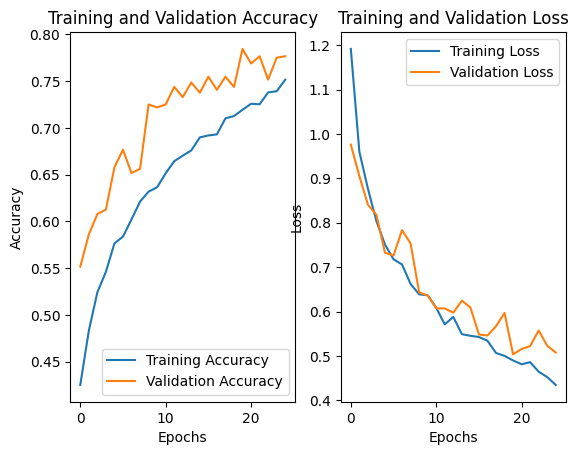

In [23]:
plot_training_history(history)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


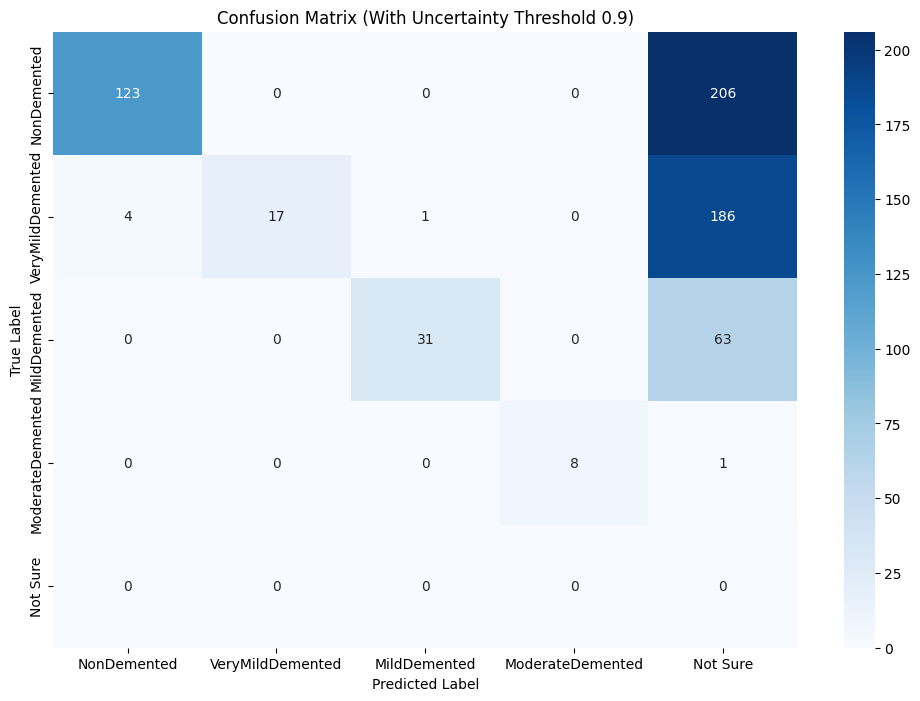


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.97      0.37      0.54       329
VeryMildDemented       1.00      0.08      0.15       208
    MildDemented       0.97      0.33      0.49        94
ModerateDemented       1.00      0.89      0.94         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.28       640
       macro avg       0.79      0.33      0.42       640
    weighted avg       0.98      0.28      0.41       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_Frozen.h5


In [24]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.9,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_Frozen.h5'
)

In [25]:
base_model.trainable = True

optimizer_fine = Adam(learning_rate=0.00001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer_fine,
              metrics=['accuracy'])

fine_tune_epochs = 100
total_epochs = 100 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 25/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 218s 102ms/step - accuracy: 0.5247 - loss: 1.0659 - val_accuracy: 0.6078 - val_loss: 0.9910 - learning_rate: 1.0000e-05
Epoch 26/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 140s 87ms/step - accuracy: 0.6256 - loss: 0.6667 - val_accuracy: 0.7063 - val_loss: 0.6736 - learning_rate: 1.0000e-05
Epoch 27/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 140s 87ms/step - accuracy: 0.7016 - loss: 0.5158 - val_accuracy: 0.7344 - val_loss: 0.5672 - learning_rate: 1.0000e-05
Epoch 28/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 141s 87ms/step - accuracy: 0.7543 - loss: 0.4203 - val_accuracy: 0.8203 - val_loss: 0.4456 - learning_rate: 1.0000e-05
Epoch 29/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 141s 87ms/step - accuracy: 0.7936 - loss: 0.3833 - val_accuracy: 0.8281 - val_loss: 0.4068 - learning_rate: 1.0000e-05
Epoch 30/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 142s 88ms/step - accuracy: 0.8326 - loss: 0.3089 - val_accuracy: 0.8500 - val_loss: 0.3325 - learning_rate: 1.0000e-05
Epoch 31/200
1548/154

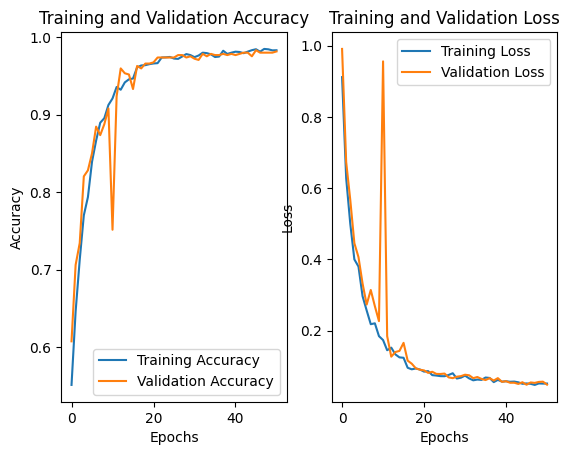

In [26]:
plot_training_history(history_fine)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


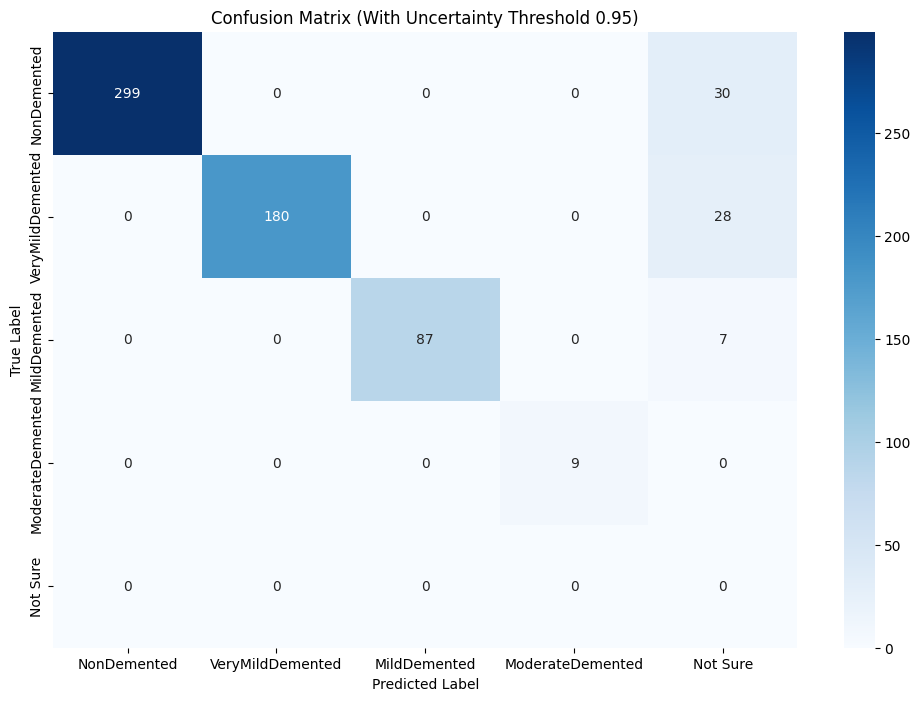


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.91      0.95       329
VeryMildDemented       1.00      0.87      0.93       208
    MildDemented       1.00      0.93      0.96        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.90       640
       macro avg       0.80      0.74      0.77       640
    weighted avg       1.00      0.90      0.95       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [30]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.95,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


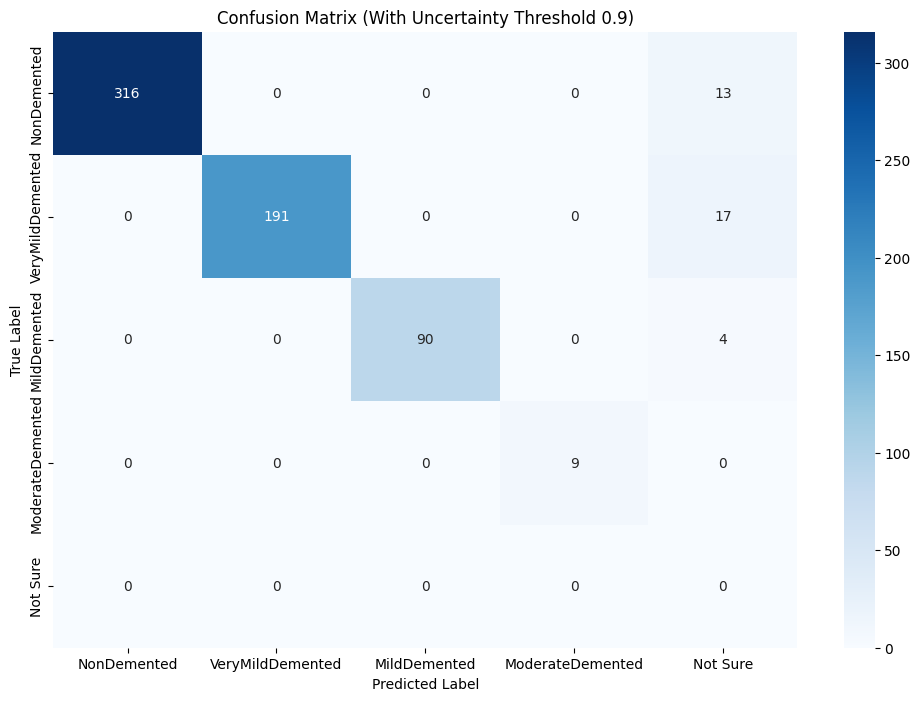


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.96      0.98       329
VeryMildDemented       1.00      0.92      0.96       208
    MildDemented       1.00      0.96      0.98        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.95       640
       macro avg       0.80      0.77      0.78       640
    weighted avg       1.00      0.95      0.97       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [27]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.9,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


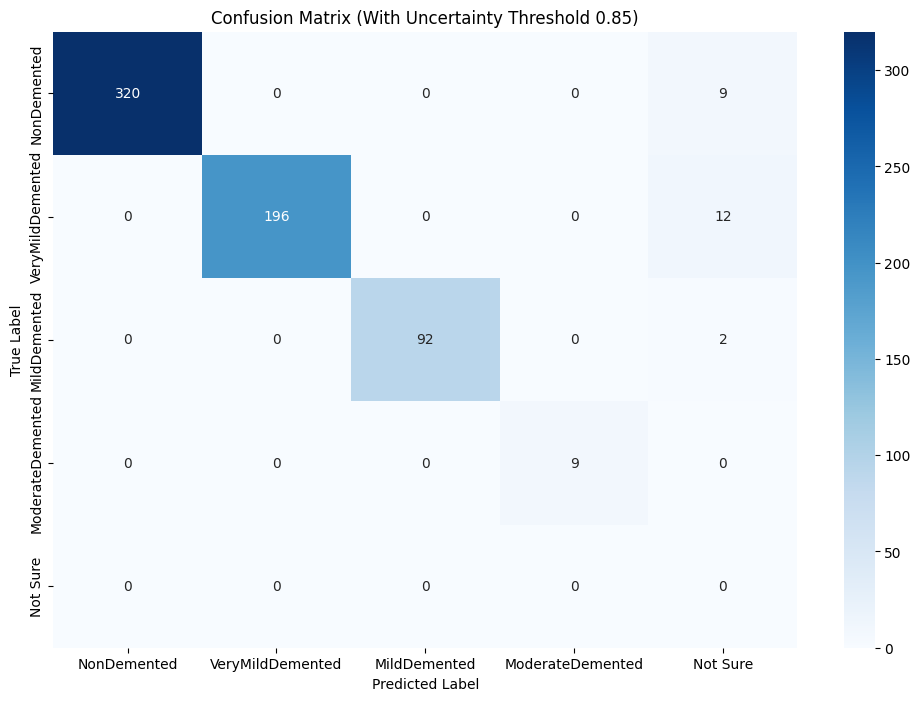


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.97      0.99       329
VeryMildDemented       1.00      0.94      0.97       208
    MildDemented       1.00      0.98      0.99        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.96       640
       macro avg       0.80      0.78      0.79       640
    weighted avg       1.00      0.96      0.98       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [31]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.85,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


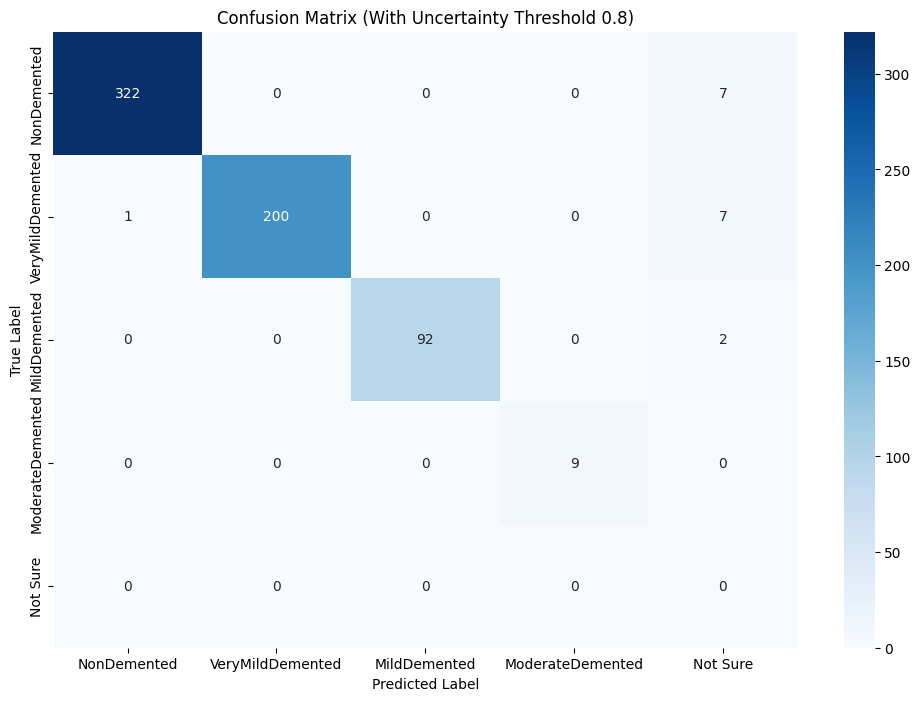


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.98      0.99       329
VeryMildDemented       1.00      0.96      0.98       208
    MildDemented       1.00      0.98      0.99        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.97       640
       macro avg       0.80      0.78      0.79       640
    weighted avg       1.00      0.97      0.99       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [29]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.8,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


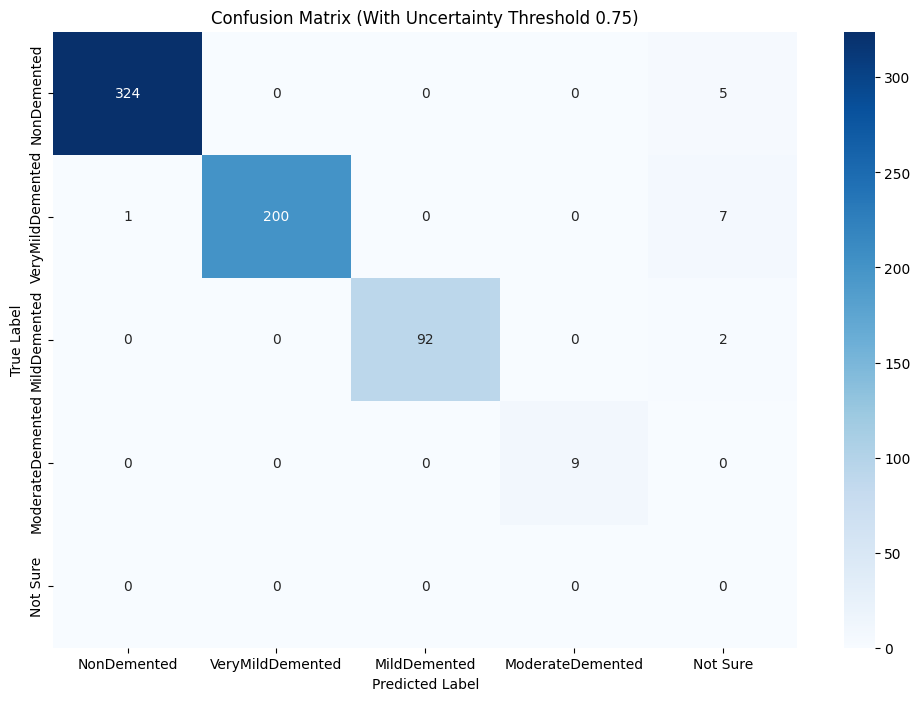


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.98      0.99       329
VeryMildDemented       1.00      0.96      0.98       208
    MildDemented       1.00      0.98      0.99        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.98       640
       macro avg       0.80      0.79      0.79       640
    weighted avg       1.00      0.98      0.99       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [32]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.75,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


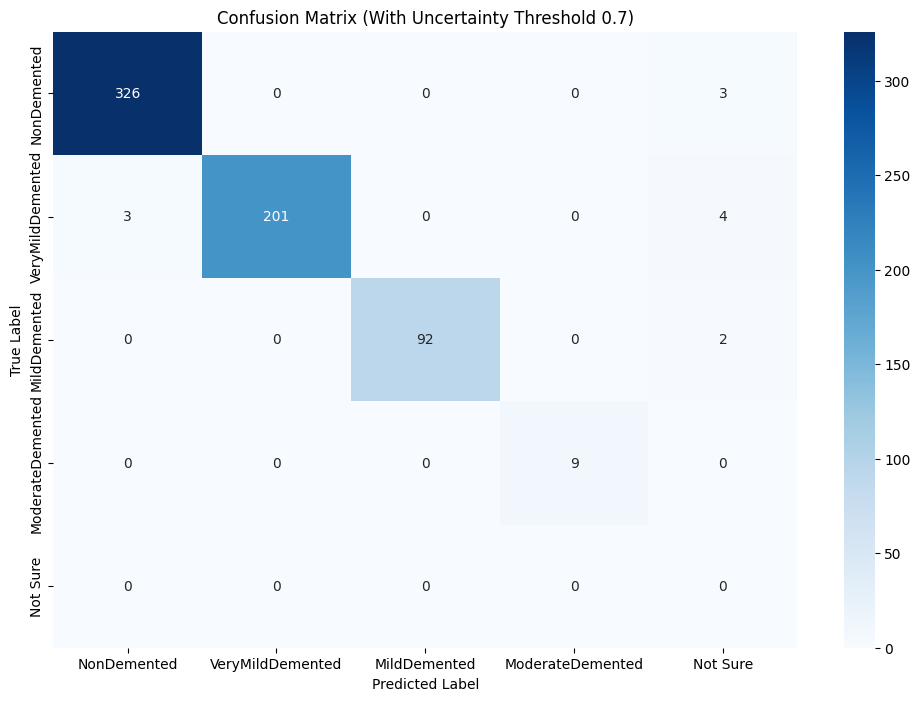


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      0.99      0.99       329
VeryMildDemented       1.00      0.97      0.98       208
    MildDemented       1.00      0.98      0.99        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.98       640
       macro avg       0.80      0.79      0.79       640
    weighted avg       1.00      0.98      0.99       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [33]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.7,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


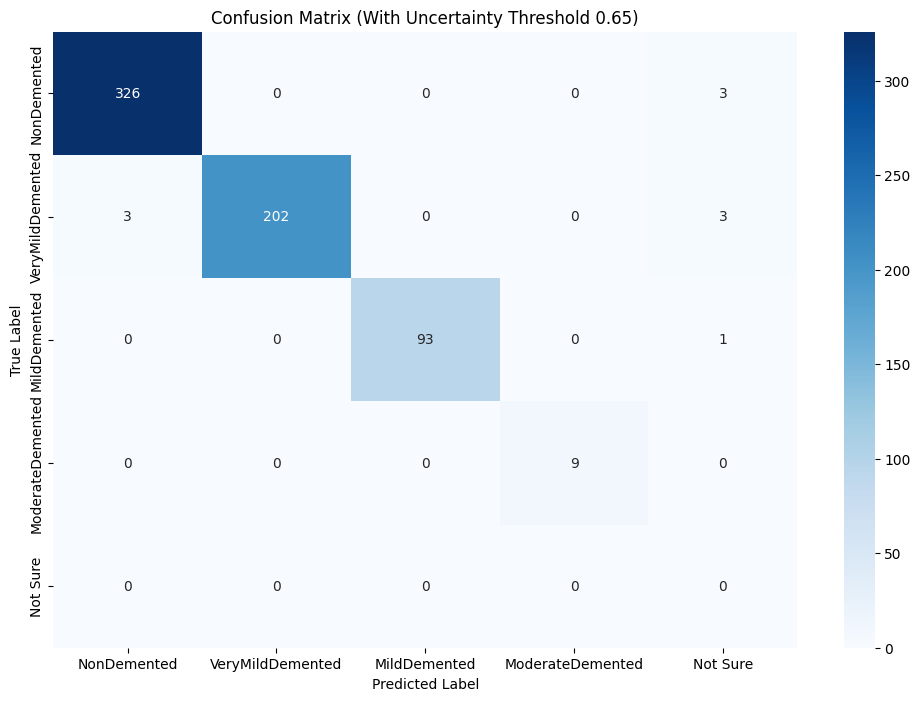


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      0.99      0.99       329
VeryMildDemented       1.00      0.97      0.99       208
    MildDemented       1.00      0.99      0.99        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.98       640
       macro avg       0.80      0.79      0.79       640
    weighted avg       1.00      0.98      0.99       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [34]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.65,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


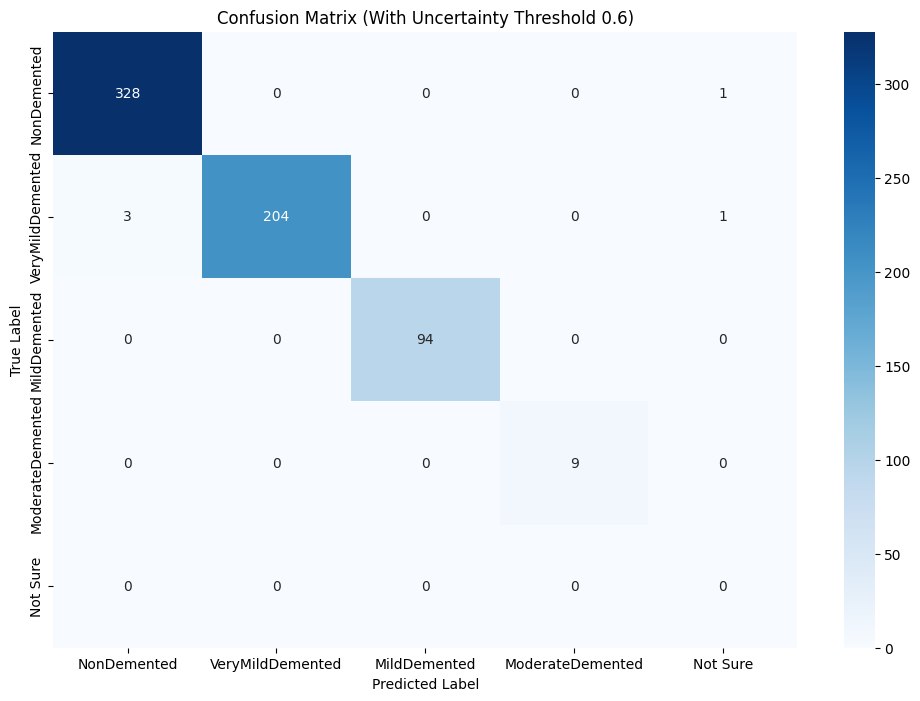


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      1.00      0.99       329
VeryMildDemented       1.00      0.98      0.99       208
    MildDemented       1.00      1.00      1.00        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.99       640
       macro avg       0.80      0.80      0.80       640
    weighted avg       1.00      0.99      0.99       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [35]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.6,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


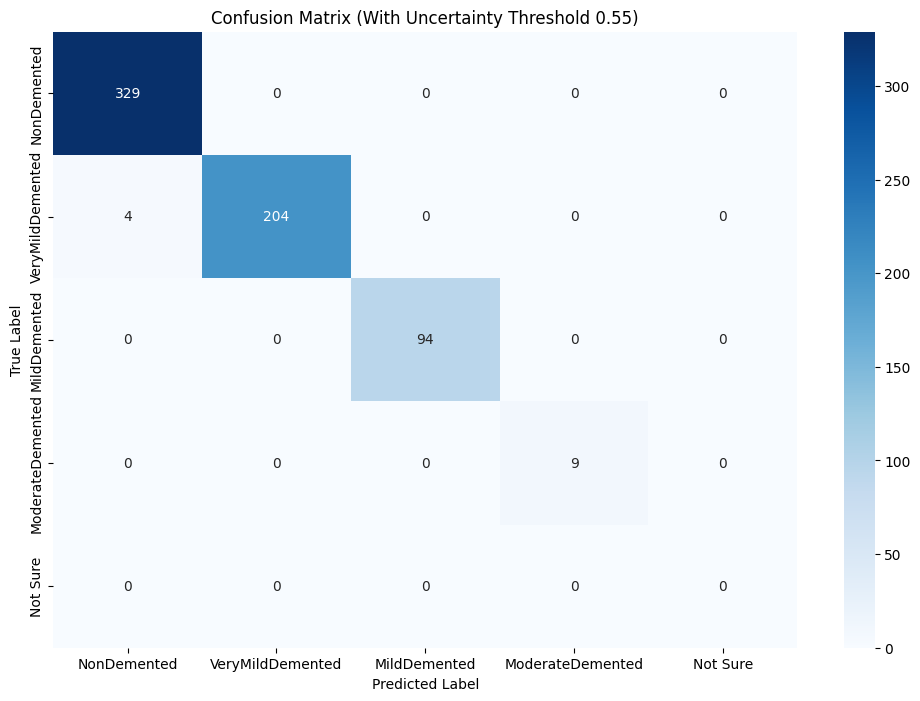


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      1.00      0.99       329
VeryMildDemented       1.00      0.98      0.99       208
    MildDemented       1.00      1.00      1.00        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

       micro avg       0.99      0.99      0.99       640
       macro avg       0.80      0.80      0.80       640
    weighted avg       0.99      0.99      0.99       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [28]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.55,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)

⏳ Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


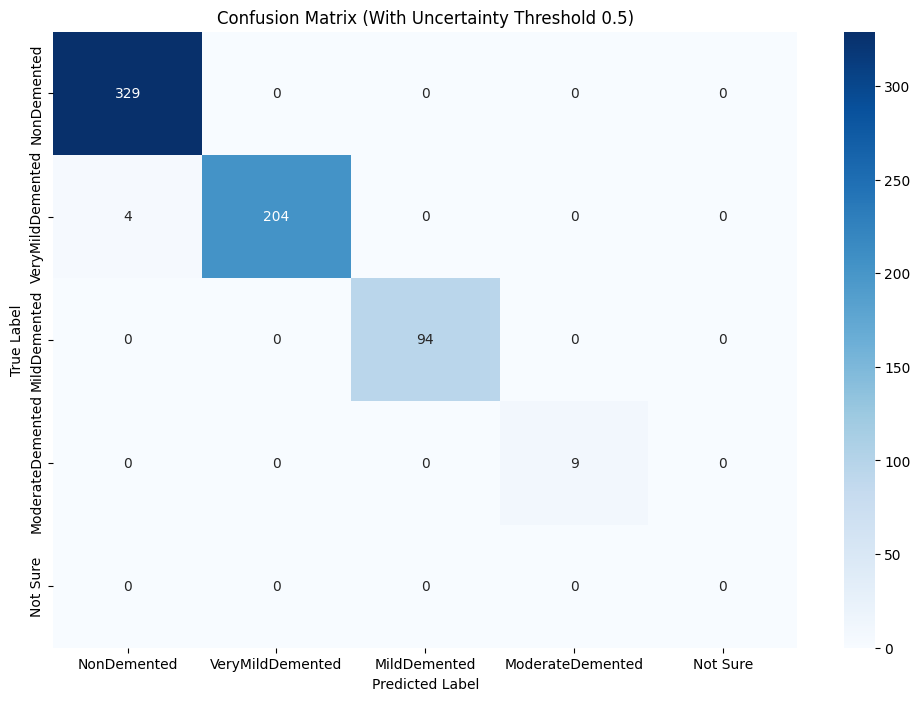


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      1.00      0.99       329
VeryMildDemented       1.00      0.98      0.99       208
    MildDemented       1.00      1.00      1.00        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

       micro avg       0.99      0.99      0.99       640
       macro avg       0.80      0.80      0.80       640
    weighted avg       0.99      0.99      0.99       640

✅ Model saved successfully as: Resnet_50_Model_MultiClass_UnFrozen.h5


In [36]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.5,
    class_names= class_names,
    save_name='Resnet_50_Model_MultiClass_UnFrozen.h5'
)